In [1]:
from torch import nn


class Generator(nn.Module):
    def __init__(
        self,
        gen_input_nc,
        image_nc,
    ):
        super(Generator, self).__init__()

        encoder_lis = [
            # MNIST:1*28*28
            nn.Conv2d(gen_input_nc, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # 8*26*26
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # 16*12*12
            # nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            # nn.InstanceNorm2d(32),
            # nn.ReLU(),
            # 32*5*5
        ]

        bottle_neck_lis = [
            ResnetBlock(16),
            # ResnetBlock(32),
            # ResnetBlock(32),
            # ResnetBlock(32),
        ]

        decoder_lis = [
            # nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            # nn.InstanceNorm2d(16),
            # nn.ReLU(),
            # state size. 16 x 11 x 11
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size. 8 x 23 x 23
            nn.ConvTranspose2d(
                8, image_nc, kernel_size=4, stride=1, padding=0, bias=False
            ),
            nn.Tanh()
            # state size. image_nc x 28 x 28
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x


# Define a resnet block
# modified from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
class ResnetBlock(nn.Module):
    def __init__(
        self,
        dim,
        padding_type="reflect",
        norm_layer=nn.BatchNorm2d,
        use_dropout=False,
        use_bias=False,
    ):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(
            dim, padding_type, norm_layer, use_dropout, use_bias
        )

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
            norm_layer(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
            norm_layer(dim),
        ]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [11]:
g = Generator(1, 1)

In [3]:
print(g)

Generator(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
  )
  (bottle_neck): Sequential(
    (0): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3

In [4]:
from pathlib import Path
from config import FACESWAP_PATH

from torch import nn

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

class Target(nn.Module):
    def __init__(self, ngpu):
        super(Target, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# import subprocess

# class Model:

#     def __init__(self):
#         pass

#     def center_box(self, row, col, image):
#         pass

#     def extract(self, input_dir, output_dir):
#         """Extracts faces from photos"""
#         subprocess.run([
#             "python",
#             FACESWAP_PATH,
#             "extract",
#             "-i",
#             input_dir,
#             "-o",
#             output_dir
#         ])
        
    
#     def convert(self, input_dir, output_dir):
#         """Swaps the faces from the input photos to the output photos"""
#         subprocess.run([
#             "python",
#             FACESWAP_PATH,
#             "convert",
#             "-i",
#             input_dir,
#             "-o",
#             output_dir
#         ])



In [8]:
model = Target("cpu")

In [12]:
import torch
model.load_state_dict(torch.load('model/gen/gen.mod'))
model.eval()

g,load_state_dict(torch.load('models/instances/netG_epoch_60.pth'))
g.eval()

NameError: name 'load_state_dict' is not defined

In [15]:
g.load_state_dict(torch.load('models/instances/netG_epoch_60.pth'))
g.eval()

Generator(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
  )
  (bottle_neck): Sequential(
    (0): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3

In [16]:
noise = torch.randn(1, 100, 1, 1)

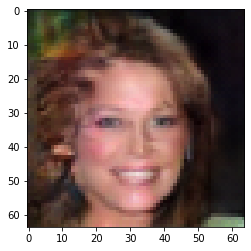

In [30]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

image = model(noise).detach()
image = vutils.make_grid(image, padding=2, normalize=True)
plt.imshow(np.transpose(image,(1,2,0)))

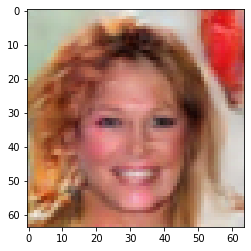

In [110]:
image = model(noise + g(noise.reshape(1, 1, 10, 10)).reshape(1, 100, 1, 1)).detach()
image = vutils.make_grid(image, padding=2, normalize=True)
plt.imshow(np.transpose(image,(1,2,0)))

In [35]:
print(torch.norm(g(noise.reshape(1, 1, 10, 10)), 2))

tensor(2.7835, grad_fn=<NormBackward0>)


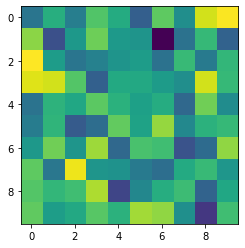

In [37]:
plt.imshow(noise.reshape(10,10))

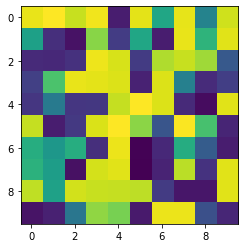

In [103]:
plt.imshow(g(noise.reshape(1, 1, 10, 10)).detach().reshape(10,10))

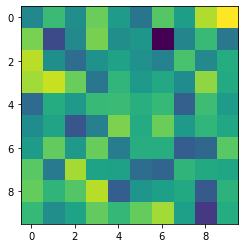

In [101]:
plt.imshow((noise + g(noise.reshape(1, 1, 10, 10)).reshape(1, 100, 1, 1)).detach().reshape(10,10))

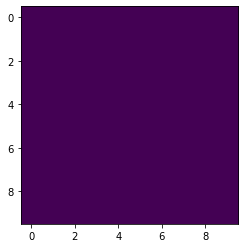

In [44]:
plt.imshow(np.zeros((10,10)))

In [84]:
per = noise + g(noise.reshape(1, 1, 10, 10))

In [93]:
(noise + g(noise.reshape(1, 1, 10, 10)))
print(noise.shape)
print(g(noise.reshape(1, 1, 10, 10)).reshape(1, 100, 1, 1).shape)
print((noise + g(noise.reshape(1, 1, 10, 10))).shape)

torch.Size([1, 100, 1, 1])
torch.Size([1, 100, 1, 1])
torch.Size([1, 100, 10, 10])
